In [28]:
import sys, os, re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sys.path.insert(0, os.getcwd() + "/../../")
from analysis.utils import histogram, abs_err, gmae
from analysis.memory_bw_utils import *

num_gpus = 4
epsilon = 4e-4
saturation_th = 0.05
superscript = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
collectives = ['all_to_all', 'all_to_allv', 'all_reduce', 'all_gather', 'all_gather_base', 'reduce', 'reduce_scatter']

In [29]:
num_of_collectives = len(collectives)
data = {}
for idx, collective in enumerate(collectives):
    d = {
        'size': [],
        'latency': [],
        'alg_bw': [],
        'bus_bw': []
    }
    filename = '../../3rdparty/param/train/comms/pt/bench_results/{}_{}.txt'.format(collective, num_gpus)
    header_found = False
    with open(filename, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if re.search('COMMS-RES', line):
                if not header_found:
                    header_found = True
                    continue
                d['size'].append(int(line.split('\t')[2].lstrip('\t')))
                d['latency'].append(float(line.split('\t')[4].lstrip('\t')))
                d['alg_bw'].append(float(line.split('\t')[-2].rstrip('\n')) + epsilon)
                d['bus_bw'].append(float(line.split('\t')[-1].rstrip('\n')) + epsilon)
        d['size'] = np.array(d['size'])
        d['latency'] = np.array(d['latency'])
        d['alg_bw'] = np.array(d['alg_bw'])
        d['bus_bw'] = np.array(d['bus_bw'])
        data[collective] = pd.DataFrame(d)

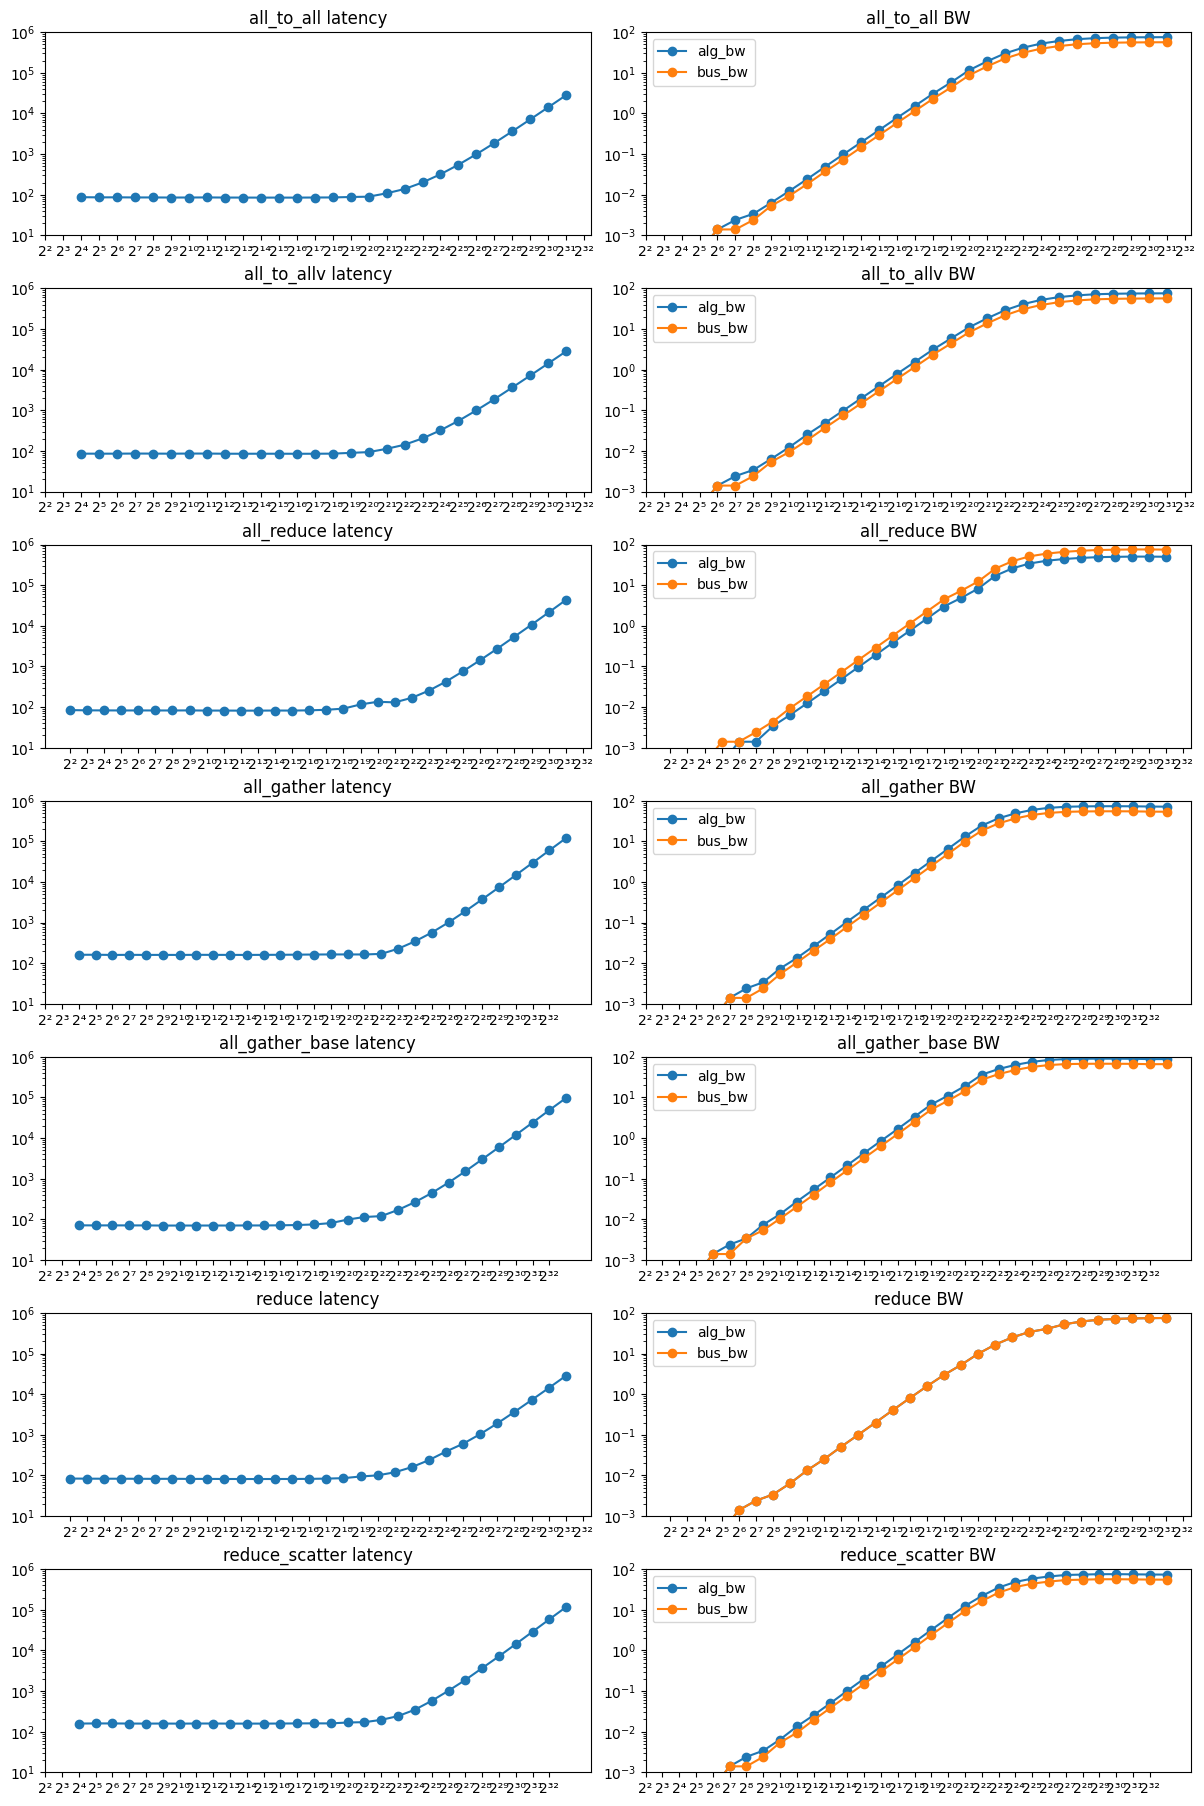

In [30]:
fig = plt.figure(figsize=(12, 18))
for idx, collective in enumerate(collectives):
    ax = fig.add_subplot(num_of_collectives, 2, idx * 2 + 1)
    ax.set_title('{} latency'.format(collective))
    ax.plot(data[collective]['size'], data[collective]['latency'], marker='o')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e1, 1e6])
    ax.set_xticks([2**i for i in range(2, 33)])
    ax.set_xticklabels(["2{}".format(str(j).translate(superscript)) for j in range(2, 33)])

    ax = fig.add_subplot(num_of_collectives, 2, idx * 2 + 2)
    ax.set_title('{} BW'.format(collective))
    ax.plot(data[collective]['size'], data[collective]['alg_bw'], marker='o')
    ax.plot(data[collective]['size'], data[collective]['bus_bw'], marker='o')
    ax.legend(['alg_bw', 'bus_bw'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-3, 1e2])
    ax.set_xticks([2**i for i in range(2, 33)])
    ax.set_xticklabels(["2{}".format(str(j).translate(superscript)) for j in range(2, 33)])

fig.tight_layout(pad=0.5)

In [31]:
# fig = plt.figure(figsize=(8, 8))
# ax1 = fig.add_subplot(3, 1, 1)
# ax2 = fig.add_subplot(3, 1, 2)
# ax3 = fig.add_subplot(3, 1, 3)
# for idx, collective in enumerate(collectives):
    
#     ax1.plot(data[collective]['size'], data[collective]['latency'], marker='o')
#     ax1.set_xscale('log')
#     ax1.set_yscale('log')
#     ax1.set_ylim([1e1, 1e6])
#     ax1.set_xticks([2**i for i in range(2, 33)])
#     ax1.set_xticklabels(["2{}".format(str(j).translate(superscript)) for j in range(2, 33)])
#     ax1.set_xlabel("Message size (bytes)", fontsize=12)
#     ax1.set_ylabel("Latency (us)", fontsize=12)

#     ax2.plot(data[collective]['size'], data[collective]['bus_bw'], marker='o')
#     ax2.set_xscale('log')
#     ax2.set_yscale('log')
#     ax2.set_ylim([1e-3, 1e2])
#     ax2.set_xticks([2**i for i in range(2, 33)])
#     ax2.set_xticklabels(["2{}".format(str(j).translate(superscript)) for j in range(2, 33)])
#     ax2.set_xlabel("Message size (bytes)", fontsize=12)
#     ax2.set_ylabel("Bus BW (GB/s)", fontsize=12)

#     ax3.plot(data[collective]['size'], data[collective]['alg_bw'], marker='o')
#     ax3.set_xscale('log')
#     ax3.set_yscale('log')
#     ax3.set_ylim([1e-3, 1e2])
#     ax3.set_xticks([2**i for i in range(2, 33)])
#     ax3.set_xticklabels(["2{}".format(str(j).translate(superscript)) for j in range(2, 33)])
#     ax3.set_xlabel("Message size (bytes)", fontsize=12)
#     ax3.set_ylabel("Alg BW (GB/s)", fontsize=12)

# ax1.legend(collectives)
# ax2.legend(collectives)
# ax3.legend(collectives)
# fig.suptitle("Communication collectives microbenchmark on a quad-V100 DGX-1", fontsize=14)
# fig.tight_layout(pad=0.5)
# plt.savefig('../../3rdparty/param/train/comms/pt/latency_bw.png', bbox_inches='tight')

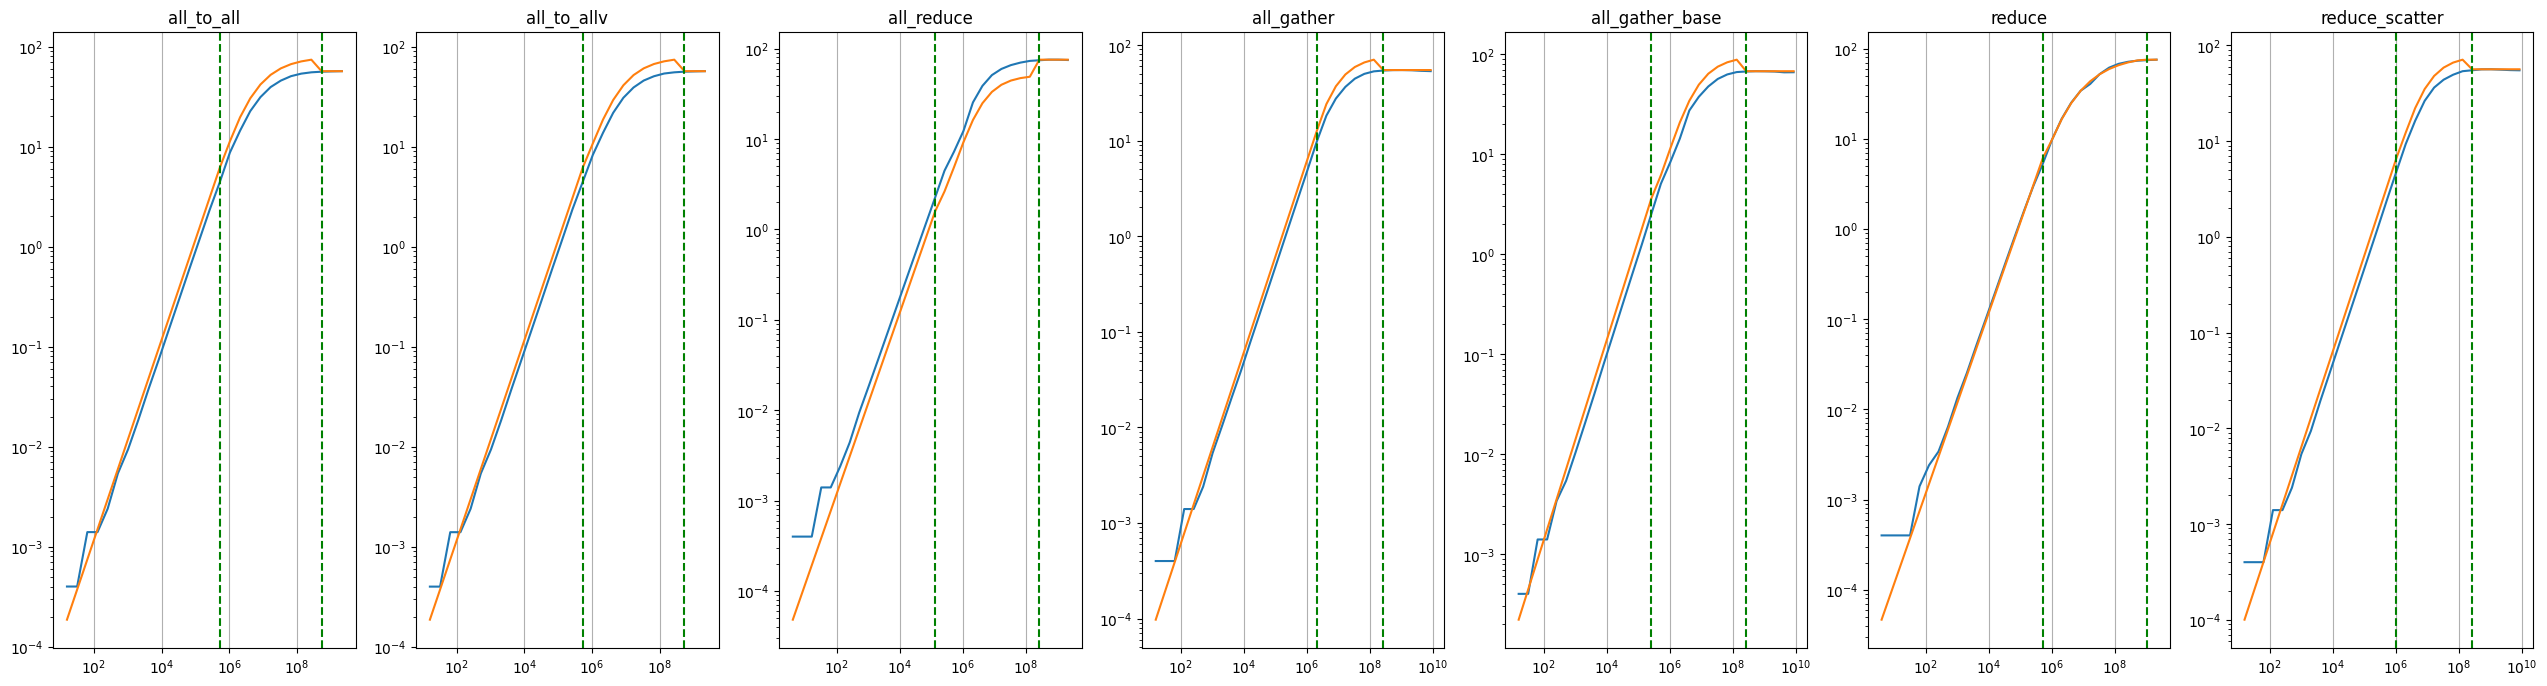

In [32]:
# Get slopes of for the 2nd section of the curves
mem_chs = {}
sigmoid_params = {}
fig, axs = plt.subplots(1, len(collectives), figsize=(32, 8))
for idx, collective in enumerate(collectives):
    mem_chs[collective] = get_memory_characteristics(data[collective])
    f_mul_factor = MUL_FACTOR_FUNCS[collective](num_gpus)
    sigmoid_params[collective] = fit_sigmoid_bw_predictor(data[collective], mem_chs[collective])
    d = {
        "mul_factor": f_mul_factor,
        "mem_ch": mem_chs[collective],
        "sigmoid_param": sigmoid_params[collective],
    }
    f1 = lambda x: predict_bw(x, **d)
    axs[idx].plot(data[collective]['size'], data[collective]['bus_bw'])
    axs[idx].plot(data[collective]['size'], data[collective]['size'].apply(f1))
    axs[idx].axvline(2 ** mem_chs[collective]["ln_p"], linestyle='--', color='green')
    axs[idx].axvline(2 ** mem_chs[collective]["sats_p"], linestyle='--', color='green')
    axs[idx].set_xscale('log')
    axs[idx].set_yscale('log')
    axs[idx].grid(axis='x')
    axs[idx].set_title(collective)

    # # Prediction
    # print("----- {} -----".format(collective))
    # for idx, size in enumerate(data[collective]['size']):
    #     f_mul_factor = MUL_FACTOR_FUNCS[collective]
    #     f_sigmoid_bw = sigmoid_params[collective](num_gpus)
    #     print("{:.2f}, {:.2f}, {:.2f}".format(
    #         data[collective]['latency'][idx],
    #         predict_linear(size, f_mul_factor, *mem_chs[collective]),
    #         predict_data_movement_time(size, f_mul_factor, mem_ch, sigmoid_param),
    #     ))

Current limitations:
- Prediction error is high near the two turning points. Probably need another way to fit the curve. Updates: sigmoid can fit the corners well.
- Is there a way to directly get the min/max BW from device connection configuration w/o benchmarking? Can the bus BW be derived from the algo BW which seems to follow a pattern (50, 75, 87.5 GB/s)?

e.g. 4 GPUs, all_to_all, each GPU sends 1/4 elements to each of the other GPUs
- --b/--e (in bytes per rank): 16, 32, 64...
- allSizes (in bytes per rank): 16, 32, 64...
- memSize / size (B) in printed results (in bytes per rank): 16, 32, 64...
- num-elements in printed results (in elements COMMUNICATED per rank-pair): 1, 2, 4...

commsParams.element_size: 4 (float)
comm_fn: backendFuncs.collectiveFunc[commsParams.collective]
comms.py comm op line 1202 calls runColl line 258
--z/commsParamsHolderBase's blockingFlag/~asyncOp 1: non-blocking, 0: blocking
gatherBenchTime line 767: gather bench time stored in tensors on each device to a list of tensors on rank 0.

param pytorch_dist_backend: all_to_all line 163 calls dist.all_to_all_single line 170, wait function called at line 389
dlrm extend_distributed: alltoall line 597 calls All2All_Req line 404 calls dist.all_to_all_single line 429 (list of local tensors concatenated and flatten to 1D)

e.g. batched_emb
dist.all_to_all_single: input_split_sizes (how tables are distributed to devices, e.g. 13 tables and [2,3,3,5] on 4 GPUs), output_split_sizes (how batches are distributed to devices; set to None for equal distribution, e.g. batch size 2048 -> 512 per GPU)
common case: input_split_sizes not None, output_split_sizes None

- reduce scatter: memSize measures the INPUT size in bytes per rank (equal to total OUTPUT size on all devices)
- all gather: memSize measures the OUTPUT size in bytes per rank (equal to total INPUT size on all devices)

In [33]:
filename = '../../3rdparty/param/train/comms/pt/bench_results/general_all_to_allv_4.txt'
header_found = False
general_data = {
    'btd': [],
    'size': [],
    'latency': [],
    'alg_bw': [],
    'bus_bw': []
}
with open(filename, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if re.search('COMMS-RES', line):
            if not header_found:
                header_found = True
                continue
            general_data['btd'].append(line.split('\t')[3].lstrip('\t'))
            general_data['size'].append(int(line.split('\t')[2].lstrip('\t')))
            general_data['latency'].append(sum([float(s) for s in line.split('\t')[6].lstrip('\t').split('-')]) / num_gpus)
            general_data['alg_bw'].append(sum([float(s) for s in line.split('\t')[4].lstrip('\t').split('-')]) / num_gpus + epsilon)
            general_data['bus_bw'].append(sum([float(s) for s in line.split('\t')[5].lstrip('\t').rstrip('\n').split('-')]) / num_gpus + epsilon)
    general_data['size'] = np.array(general_data['size'])
    general_data['latency'] = np.array(general_data['latency'])
    general_data['alg_bw'] = np.array(general_data['alg_bw'])
    general_data['bus_bw'] = np.array(general_data['bus_bw'])
df = pd.DataFrame(general_data)
df.head()

,btd,size,latency,alg_bw,bus_bw
0,"256,1-1-1-1,32",32768,90.829700,0.361175,0.270975
1,"256,1-1-1-1,64",65536,90.563850,0.724075,0.543150
2,"256,1-1-1-1,128",131072,90.493375,1.448925,1.086800
3,"256,1-1-1-1,256",262144,91.376175,2.872000,2.154100
4,"256,1-1-1-2,32",40960,91.007550,0.450950,0.338300


In [34]:
mem_ch = mem_chs['all_to_allv']
f_mul_factor = MUL_FACTOR_FUNCS["all_to_allv"](num_gpus)
sigmoid_param = sigmoid_params["all_to_allv"]
x = df['size']
y = x.apply(predict_data_movement_time, args=(f_mul_factor, mem_ch, sigmoid_param))

In [35]:
error = abs_err(y, df['latency'])
print("All to allv: GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmae(error) * 100.0, error.mean() * 100.0, error.std() * 100.0))
_ = histogram(error)

All to allv: GMAE: 6.73%, mean: 10.41%, std: 8.65%
0% - 5%: 28.98%
5% - 10%: 32.38%
10% - 15%: 13.02%
15% - 20%: 11.23%
20% - 25%: 6.73%
25% - 30%: 3.86%
30% - 40%: 3.25%
40% - 50%: 0.52%
50% - 60%: 0.03%
60% - 80%: 0.00%
80% - 100%: 0.00%
100% - 150%: 0.00%
150% - 200%: 0.00%
200% - 300%: 0.00%
300% - 400%: 0.00%


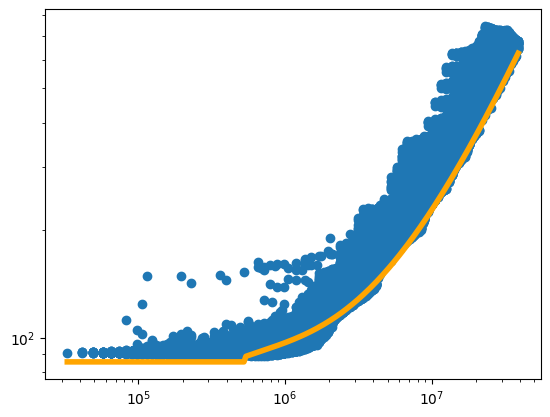

In [36]:
sorted_df = df.sort_values(['size'], ascending=[1])
fig = plt.figure()
ax = plt.gca()
ax.scatter(sorted_df['size'], sorted_df['latency'])
ax.plot(sorted_df['size'], sorted_df['size'].apply(predict_data_movement_time, args=(f_mul_factor, mem_ch, sigmoid_param)), color='orange', linewidth=4)
ax.set_yscale('log')
ax.set_xscale('log')

In [37]:
# Exploration
def get_adjusted_size(s, num_gpus, max_type):
    splitted = s.split(',')
    B = int(splitted[0]) // num_gpus
    D = int(splitted[2])
    tables = [int(t) for t in splitted[1].split('-')]
    if max_type == "max_of_max":
        T_max = max([max(sum(tables) - t, t * (num_gpus-1)) for t in tables])
    elif max_type == "max_of_sum":
        T_max = max([(sum(tables) - t + t * (num_gpus-1)) for t in tables])
    else:
        raise Exception("Unrecognized max_type")
    return B * T_max * D * 4 # float32

for max_type in ['max_of_max', 'max_of_sum']:
    adjusted_size = df['btd'].apply(get_adjusted_size, args=(num_gpus, max_type))
    y1 = adjusted_size.apply(predict_data_movement_time, args=(f_mul_factor, mem_ch, sigmoid_param))
    error1 = abs_err(y1, df['latency'])
    print("All to allv ({}): GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(max_type, gmae(error1) * 100.0, error1.mean() * 100.0, error1.std() * 100.0))
    _ = histogram(error1)

All to allv (max_of_max): GMAE: 5.31%, mean: 7.37%, std: 4.91%
0% - 5%: 33.91%
5% - 10%: 39.58%
10% - 15%: 18.21%
15% - 20%: 6.82%
20% - 25%: 1.26%
25% - 30%: 0.20%
30% - 40%: 0.02%
40% - 50%: 0.01%
50% - 60%: 0.00%
60% - 80%: 0.00%
80% - 100%: 0.00%
100% - 150%: 0.00%
150% - 200%: 0.00%
200% - 300%: 0.00%
300% - 400%: 0.00%
All to allv (max_of_sum): GMAE: 8.84%, mean: 11.82%, std: 7.05%
0% - 5%: 16.58%
5% - 10%: 26.38%
10% - 15%: 26.00%
15% - 20%: 18.63%
20% - 25%: 8.12%
25% - 30%: 2.83%
30% - 40%: 1.45%
40% - 50%: 0.01%
50% - 60%: 0.00%
60% - 80%: 0.00%
80% - 100%: 0.00%
100% - 150%: 0.00%
150% - 200%: 0.00%
200% - 300%: 0.00%
300% - 400%: 0.00%
